# OPSD EDA + Baselines

This notebook explores the OPSD time-series dataset (hourly) and establishes simple seasonal baselines (lag-24 and lag-168) to benchmark neural models.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we can import from src/ when running notebooks/
REPO_ROOT = (
    os.path.abspath(os.path.join(os.getcwd(), ".."))
    if os.path.basename(os.getcwd()) == "notebooks"
    else os.getcwd()
)
SRC_DIR = os.path.join(REPO_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from data.sqlite_opsd import load_opsd_sqlite
from data.preprocess import (
    enforce_hourly_index,
    impute_median_ffill_bfill,
    time_split_indices,
    add_calendar_features,
    add_lag_features,
    drop_initial_rows_for_lags,
)
from baselines import seasonal_naive_windows
from metrics import mae, rmse, smape

plt.rcParams["figure.figsize"] = (12, 4)

## Load data

In [ ]:
SQLITE_PATH = os.path.join(REPO_ROOT, "data", "raw", "opsd_time_series", "time_series.sqlite")
TABLE = "time_series_60min_singleindex"
TS_COL = "utc_timestamp"

TARGET = "DE_LU_load_actual_entsoe_transparency"
FEATURES = [
    "DE_LU_load_actual_entsoe_transparency",
    "DE_LU_solar_generation_actual",
    "DE_LU_wind_generation_actual",
    "DE_LU_wind_onshore_generation_actual",
    "DE_LU_wind_offshore_generation_actual",
    "DE_LU_price_day_ahead",
    "DE_LU_load_forecast_entsoe_transparency",
]

START_UTC = None   
END_UTC = None     

df = load_opsd_sqlite(
    sqlite_path=SQLITE_PATH,
    table=TABLE,
    timestamp_col=TS_COL,
    columns=list(dict.fromkeys(FEATURES + [TARGET])),
    start_utc=START_UTC,
    end_utc=END_UTC,
)

df = enforce_hourly_index(df, TS_COL)
df = impute_median_ffill_bfill(df, list(dict.fromkeys(FEATURES + [TARGET])))

df.head()


,utc_timestamp,DE_LU_load_actual_entsoe_transparency,DE_LU_solar_generation_actual,DE_LU_wind_generation_actual,DE_LU_wind_onshore_generation_actual,DE_LU_wind_offshore_generation_actual,DE_LU_price_day_ahead,DE_LU_load_forecast_entsoe_transparency
0,2014-12-31 23:00:00+00:00,55102.5,156.0,11728.0,8890.5,2755.0,36.15,54848.0
1,2015-01-01 00:00:00+00:00,55102.5,156.0,11728.0,8890.5,2755.0,36.15,54848.0
2,2015-01-01 01:00:00+00:00,55102.5,156.0,11728.0,8890.5,2755.0,36.15,54848.0
3,2015-01-01 02:00:00+00:00,55102.5,156.0,11728.0,8890.5,2755.0,36.15,54848.0
4,2015-01-01 03:00:00+00:00,55102.5,156.0,11728.0,8890.5,2755.0,36.15,54848.0


## Basic sanity checks

In [3]:
print("rows:", len(df))
print("columns:", df.shape[1])
print("time span:", df[TS_COL].min(), "->", df[TS_COL].max())

df[[TARGET]].describe()


rows: 50401
columns: 8
time span: 2014-12-31 23:00:00+00:00 -> 2020-09-30 23:00:00+00:00


,DE_LU_load_actual_entsoe_transparency
count,50401.000000
mean,55263.326293
std,5921.345772
min,32237.000000
25%,55102.500000
50%,55102.500000
75%,55102.500000
max,77172.000000


### Missingness (post-impute)

In [4]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(20)


Series([], dtype: float64)

## Plot target over time

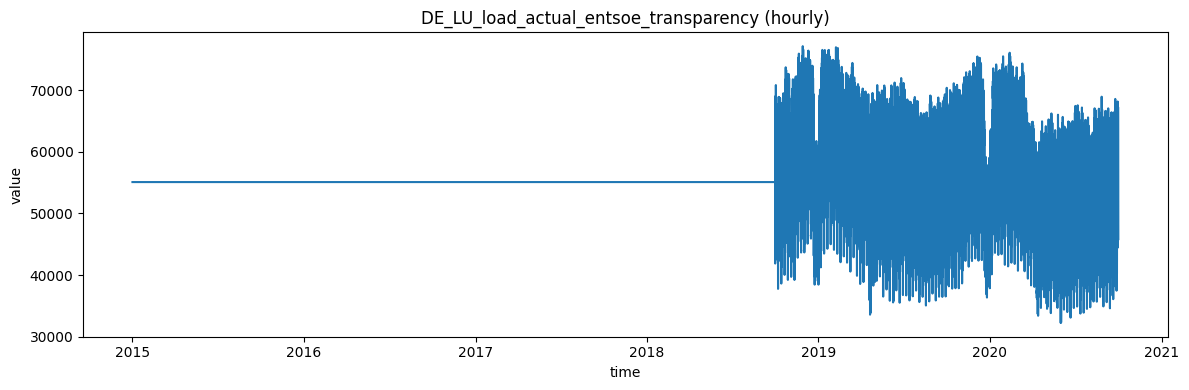

In [5]:
plt.figure()
plt.plot(pd.to_datetime(df[TS_COL]), df[TARGET])
plt.title(f"{TARGET} (hourly)")
plt.xlabel("time")
plt.ylabel("value")
plt.tight_layout()
plt.show()


## Seasonality views

Average load by hour-of-day and day-of-week.

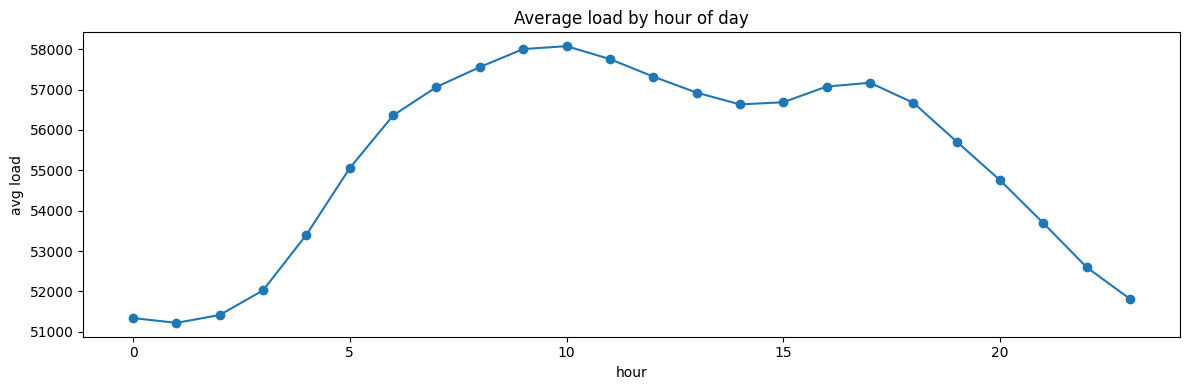

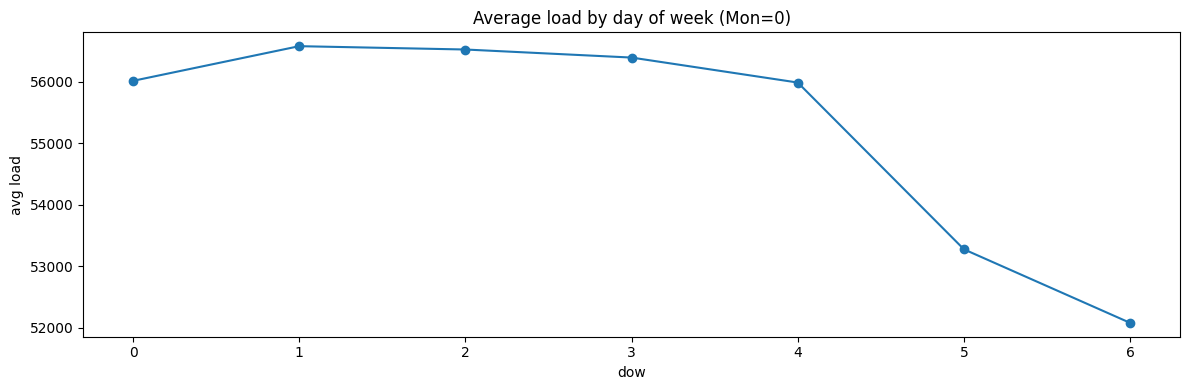

In [6]:
ts = pd.to_datetime(df[TS_COL])
tmp = df.copy()
tmp["hour"] = ts.dt.hour
tmp["dow"] = ts.dt.dayofweek

hour_mean = tmp.groupby("hour")[TARGET].mean()
dow_mean = tmp.groupby("dow")[TARGET].mean()

plt.figure()
plt.plot(hour_mean.index, hour_mean.values, marker="o")
plt.title("Average load by hour of day")
plt.xlabel("hour")
plt.ylabel("avg load")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(dow_mean.index, dow_mean.values, marker="o")
plt.title("Average load by day of week (Mon=0)")
plt.xlabel("dow")
plt.ylabel("avg load")
plt.tight_layout()
plt.show()


## Feature correlations (quick look)

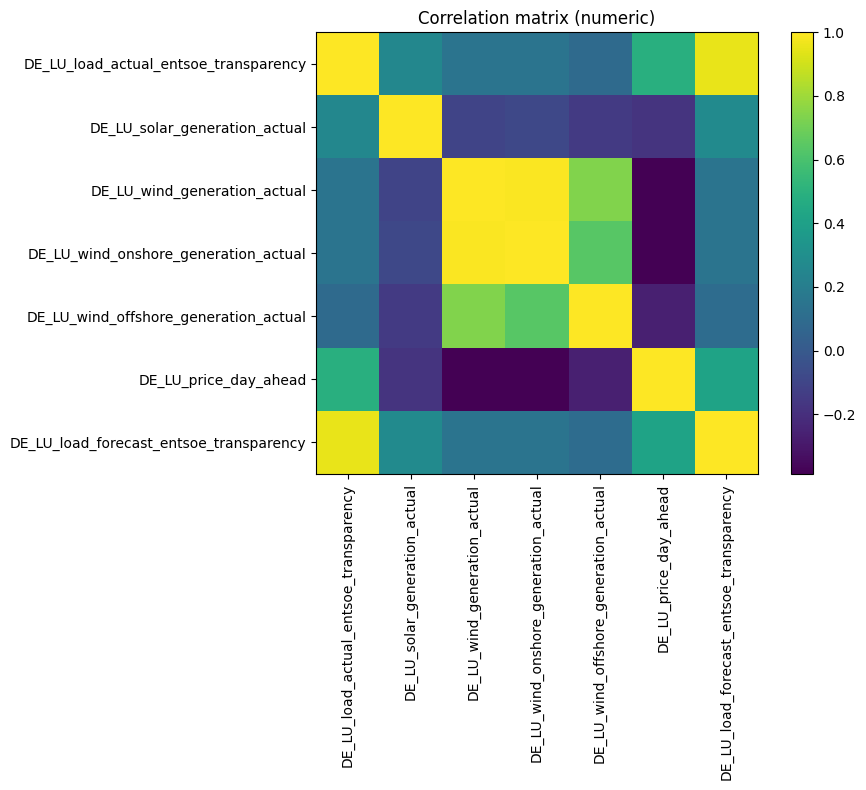

In [7]:
corr_cols = list(dict.fromkeys(FEATURES + [TARGET]))
corr = df[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.title("Correlation matrix (numeric)")
plt.tight_layout()
plt.show()


## Autocorrelation by lag

Compute autocorrelation for a few lags (daily/weekly).

lag   1: autocorr=0.9687
lag   2: autocorr=0.8883
lag   3: autocorr=0.7772
lag   6: autocorr=0.3968
lag  12: autocorr=0.0531
lag  24: autocorr=0.7787
lag  48: autocorr=0.5615
lag  72: autocorr=0.5131
lag 168: autocorr=0.9039


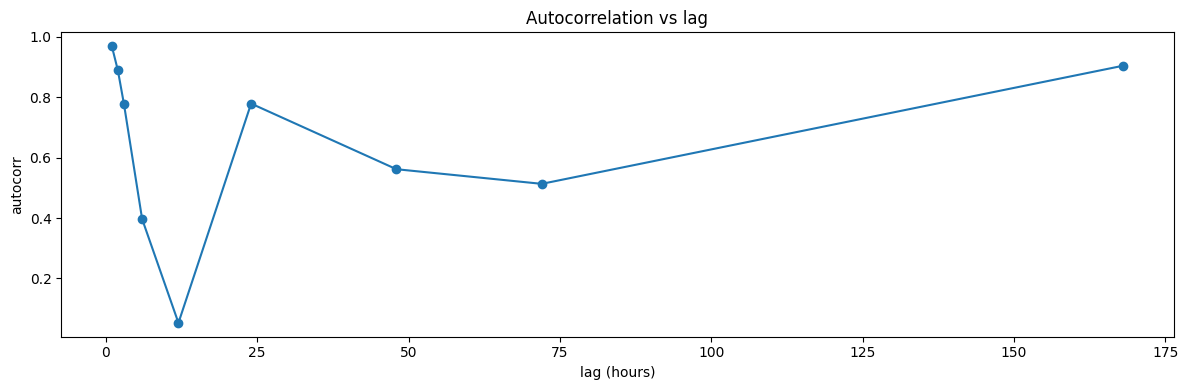

In [8]:
y = pd.Series(df[TARGET].values)
lags = [1, 2, 3, 6, 12, 24, 48, 72, 168]
acs = [y.autocorr(lag=lag) for lag in lags]

for lag, a in zip(lags, acs):
    print(f"lag {lag:>3d}: autocorr={a:.4f}")

plt.figure()
plt.plot(lags, acs, marker="o")
plt.title("Autocorrelation vs lag")
plt.xlabel("lag (hours)")
plt.ylabel("autocorr")
plt.tight_layout()
plt.show()


## Baselines on the same splits as training

We reproduce the split logic and evaluate lag-24 and lag-168 baselines.

In [9]:
# Apply same feature engineering used in training (calendar + lags) so indexing matches
# NOTE: baselines only need y_raw; we do this mainly to keep split sizes aligned if you drop rows for lags.
tmp = df.copy()
tmp, cal_cols = add_calendar_features(tmp, TS_COL)
tmp, lag_cols = add_lag_features(tmp, TARGET, [24, 168])
tmp = drop_initial_rows_for_lags(tmp, [24, 168])

y_raw = tmp[TARGET].to_numpy(dtype=np.float64)

T = len(tmp)
tr, va, te = time_split_indices(T, 0.70, 0.15)

lookback = 168
horizon = 24

# Baselines
val_y24_true, val_y24_pred = seasonal_naive_windows(y_raw, va.start, va.stop, lookback, horizon, season=24)
val_y168_true, val_y168_pred = seasonal_naive_windows(y_raw, va.start, va.stop, lookback, horizon, season=168)

test_y24_true, test_y24_pred = seasonal_naive_windows(y_raw, te.start, te.stop, lookback, horizon, season=24)
test_y168_true, test_y168_pred = seasonal_naive_windows(y_raw, te.start, te.stop, lookback, horizon, season=168)

def score(y_true, y_pred):
    return {"RMSE": rmse(y_true, y_pred), "MAE": mae(y_true, y_pred), "sMAPE": smape(y_true, y_pred)}

print("VAL  lag24 :", score(val_y24_true, val_y24_pred))
print("VAL  lag168:", score(val_y168_true, val_y168_pred))
print("TEST lag24 :", score(test_y24_true, test_y24_pred))
print("TEST lag168:", score(test_y168_true, test_y168_pred))


VAL  lag24 : {'RMSE': 7118.7716287776275, 'MAE': 4665.408258442266, 'sMAPE': 8.613727360704633}
VAL  lag168: {'RMSE': 3992.635487917325, 'MAE': 2295.2211102033407, 'sMAPE': 4.20655701429277}
TEST lag24 : {'RMSE': 6182.093955229945, 'MAE': 4085.158230074437, 'sMAPE': 7.801819555203111}
TEST lag168: {'RMSE': 4163.5751372615405, 'MAE': 2436.9751043936094, 'sMAPE': 4.625449339876554}


## Visualize baseline vs actual for one week

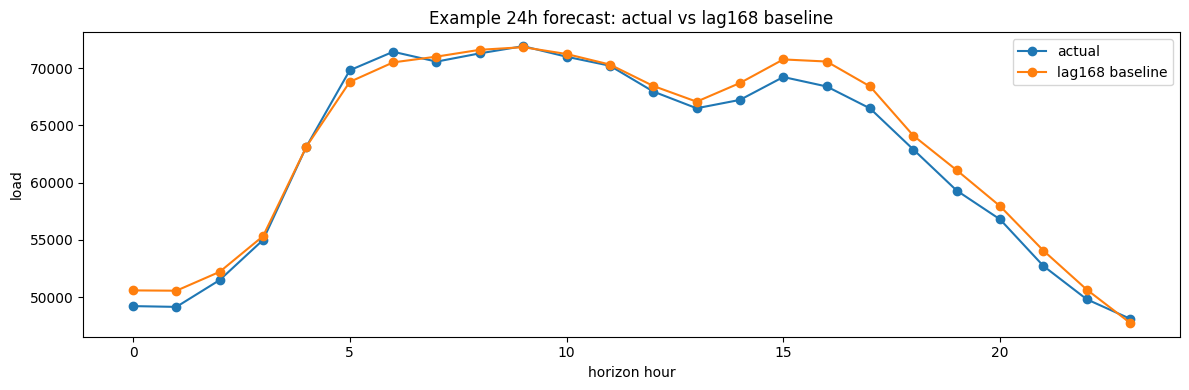

In [10]:
# Pick a window near the beginning of the test set
i = 0
y_true = test_y168_true[i]
y_pred = test_y168_pred[i]

plt.figure()
plt.plot(range(len(y_true)), y_true, marker="o", label="actual")
plt.plot(range(len(y_pred)), y_pred, marker="o", label="lag168 baseline")
plt.title("Example 24h forecast: actual vs lag168 baseline")
plt.xlabel("horizon hour")
plt.ylabel("load")
plt.legend()
plt.tight_layout()
plt.show()
